In [ ]:
!pip install top2vec
!pip install top2vec[sentence_encoders]
!pip install top2vec[sentence_transformers]
!pip install plotly==5.2.1
!pip install -U kaleido

In [2]:
#Basic Python and Machine learning libraries
import os, sys, warnings, random, time, re, math, string, copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import json
from string import punctuation
from collections import Counter,defaultdict
from re import search
from scipy import stats

from wordcloud import WordCloud, STOPWORDS

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# sklearn data science models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso
from sklearn.svm import LinearSVC
import xgboost as xgb

from bs4 import BeautifulSoup

import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize.casual import casual_tokenize
from nltk.util import ngrams
from nltk import pos_tag

import spacy

warnings.filterwarnings('ignore')

#tqdm with pandas
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

from natsort import natsorted
from preprocess_utils import contraction_mapping, map_old_new

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
fname = '/content/drive/MyDrive/intern-unsw/assets/upnishads_texts/108upanishads.txt'
with open(fname, 'r', encoding='utf-8-sig') as f:
  data = f.read()
  f.close()

In [6]:
def veda_to_upanishads(raw_data):
  '''
  get the names of all 108 upanishads from raw data
  Args:
    raw_data: unprocessed data
  Return:
    all_upanishads: dictioanry with vedas name as key and upanishads list as values
  '''
  raw_data = raw_data.replace('\x0c', '')#remove unicode
  raw_data = raw_data.replace('*', '')#remove asterics
  data_split_newline = raw_data.split('\n')
  
  veda_to_upanishads = defaultdict(list)

  
  all_upanishads_rig_ = [x for x in data_split_newline[33880:33891]]
  all_upanishads_syv_ = [x for x in data_split_newline[33893:33912]]
  all_upanishads_kyv_ = [x for x in data_split_newline[33914:33947]]
  all_upanishads_sam_ = [x for x in data_split_newline[33949:33965]]
  all_upanishads_ath_ = [x for x in data_split_newline[33967:33999]]


  #Rig Veda
  for i, name in enumerate(all_upanishads_rig_):
    if len(name) > 0:
      name = name.strip().split(' ')[1] 
      veda_to_upanishads["Rig-Veda"].append(name)
  #Sukla_yajur_veda

  for i, name in enumerate(all_upanishads_syv_):
    if len(name) > 0:
      name = name.strip().split(' ')[1] 
      veda_to_upanishads["Sukla-Yajur-Veda"].append(name)
  # Krishna-Yajur-Veda

  for i, name in enumerate(all_upanishads_kyv_):
    if len(name) > 0:
      name = name.strip().split(' ')[1] 
      veda_to_upanishads["Krishna-Yajur-Veda"].append(name)
  # Sama-Veda

  for i, name in enumerate(all_upanishads_sam_):
    if len(name) > 0:
      name = name.strip().split(' ')[1] 
      veda_to_upanishads["Sama-Veda"].append(name)

  # Atharva-Veda
  for i, name in enumerate(all_upanishads_ath_):
    if len(name) > 0:
      name = name.strip().split(' ')[1] 
      veda_to_upanishads["Atharva-Veda"].append(name)
  return veda_to_upanishads
##Create dictionary for each Upanishads
veda_upanishads = veda_to_upanishads(data)
# veda_upanishads

In [7]:
def get_upanishads_names(raw_data):
  '''
  get the names of all 108 upanishads from raw data
  Args:
    raw_data: unprocessed data
  Return:
    all_upanishads: list of all 108 upanishads
  '''
  raw_data = raw_data.replace('\x0c', '')#remove unicode
  raw_data = raw_data.replace('*', '')#
  data_split_newline = raw_data.split('\n')
  
  all_upanishads = []
  all_upanishads_ = [x for x in data_split_newline[16:128]]

  for i, name in enumerate(all_upanishads_):
    if len(name) > 0 and "Followed by" not in name:
      name = name.strip().split(' ')[1] 
      all_upanishads.append(name)
  return all_upanishads
##Create dictionary for each Upanishads
all_upanishads = get_upanishads_names(data)
# len(all_upanishads)

In [8]:
# re.findall(r"End of .*Commentary", data)
# re.findall(r"(Here ends the .*panishad.*Veda\.)", data)

In [9]:
def create_upanishads_dict(raw_data):
  '''
  Create a dictionary for each Upanished contained with texts 
  '''
  # all_upanishads = get_upanishads_names(raw_data)
  # print(len(all_upanishads))
  raw_data = data.replace('\x0c', '')
  all_match = re.findall(r"(Here ends the .*panishad.*Veda\.)", raw_data)

  #both part contais the explanation of same upanishad so combine them
  #all_match.remove('Here ends the Mandukyopanishad, included in the Atharva-Veda.')
  all_match.remove('Here ends the Mandukyopanishad, as contained in the Atharva-Veda.')
  all_match.remove('Here ends the Nrisimha Poorva Tapaniyopanishad, as contained in the Atharva-Veda.')
  #print(len(all_match))
  #some text contains commentry by Swami Nirmalananda Giri
  #print(len(all_upanishads),len(all_match))
  commentary_list = re.findall(r"End of .*Commentary", raw_data)

  upan_dict = {}
  start_idx = raw_data.find("Isavasya Upanishad");

  for idx , match in enumerate(all_match):
    upan = match.strip().split(" ")[3]
    #upan = all_upanishads[idx]
    # print(upan, ":", match)
    if upan.endswith(","):
      upan = upan[:-1]#remove comma in the end
    #print(upan)
    end_idx = raw_data.find(all_match[idx])

    #first 10 upanishads contains commentary
    if idx < 10:
      end_idx = raw_data.find(commentary_list[idx])
      upan_dict[upan] = r"{}".format(raw_data[start_idx:end_idx+len(commentary_list[idx])])
      start_idx = end_idx+len(commentary_list[idx])+1
    else:
      upan_dict[upan] = r"{}".format(raw_data[start_idx:end_idx+len(match)])
      start_idx = end_idx+len(match)+1
    # if upan == 'Mandukyopanishad':
    #   print(upan_dict[upan])
  return upan_dict
upan_dict = create_upanishads_dict(data)

In [10]:
def rename_keys_upanishad_dict(new_key_list, upanishad_dict):
  '''
  rename keys to simple names of upanishads
  return:
      upanishad dict with renamed keys
  '''
  upanishad_dict = dict(zip(new_key_list,list(upanishad_dict.values())))

  return upanishad_dict

new_upan_dict = rename_keys_upanishad_dict(all_upanishads, upan_dict)

In [11]:
with open('all_upanishads.json', 'w') as fp:
    json.dump(new_upan_dict, fp,indent=4)

In [12]:
def remove_beginning_lines(data):
  """
  Remove the beginning lines, like translated by, published by, and upanishads name
  """
  data_list = data.split('\n')
  
  data_list = [x for x in data_list if len(x)> 0]
  
  data_list = data_list[1:]#remove name of the upanishads
  
  if "Translated by" in data_list[0]:
    data_list = data_list[1:]
  if "Published by" in data_list[0]:
    data_list = data_list[1:]

  data = "\n".join(data_list)
  
  return data

def replace_words_contraction(data, map_old_new, contraction_map):
  """
  Replace old and archaic words
  """
  for new_old, word in zip(map_old_new.keys(), contraction_map.keys()):
    data = data.replace(new_old, map_old_new[new_old])
    data = data.replace(word, contraction_map[word])
  return data

# data_removed_begin = remove_beginning_lines(new_upan_dict['Isa'])
# print(data_removed_begin)
text = new_upan_dict['Isa']

In [13]:
def lemmatize_sentence(sentence):
  """
  Lemmatize a single sentence
  """
  lemma_sentence=[]
  wnl = WordNetLemmatizer()
  for word, tag in pos_tag(word_tokenize(sentence)):
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
      lemma = word
    else:
      lemma = wnl.lemmatize(word, wntag)
    lemma_sentence.append(lemma)
    lemma_sentence.append(" ")
  return "".join(lemma_sentence)

def lemmatize_doc(data):
  """
  Lemmatize entire documents
  """
  data_list = data.split('\n')
  
  data_list = [x for x in data_list if len(x)> 0]
  lametized_list = []
  for sentence in data_list:
    lam_sent = lemmatize_sentence(sentence)
    lametized_list.append(lam_sent)

  lametized_list = [x for x in lametized_list if len(x)> 0]
  data = "\n".join(lametized_list)
  
  return data

In [14]:
def clean_text(data):
  '''
  clean the raw text of each of the 108 upanishads
  '''
  #remove unicode
  data = data.replace('\x0c', '')

  #removes beginning line eg. Upanishad's name, translated by and published by
  data = remove_beginning_lines(data)

  #remove sloka's numbering eg. 2-III-11.,I-3:,10.etc
  data = re.sub('(.*[-][\d]+[.:])|(^[\d]+[.])', '', data)

  #remove the numbering of upanishads eg. (Atharvashikha Upanishad 1:10)
  data = re.sub('[(](?<=\()(.*? Upanishad .*?)(?=\))[)]', '', data)

  #remove the numbering of upanishads eg. (2:10)
  data = re.sub('[(](?<=\()([0-9]+:[0-9]+)(?=\))[)]', '', data)

  #remove the numberings eg. II-ii-51-56., II-21.
  data = re.sub("(.*[-][\d]+[.:])|(^[\d]+[.])|(.*[-][\d]+([a-z()]{3})[.:])", '', data)

  #remove and replace different symbols and repetitive characters
  data = data.replace('…………………', '')
  data = data.replace('………..', '')
  data = data.replace('……', '')
  data = data.replace('....', '')
  data = data.replace('...', '')
  data = data.replace('..', '')

  #replace texts
  data = data.replace('Om!', 'Om ')
  data = data.replace('Om !', 'Om')
  data = data.replace('Om! Peace! Peace! Peace!', 'Om Peace Peace Peace!')

  #remove extra texts like commentary by ...
  data = re.sub('.*by Swami Nirmalananda Giri.', '', data)
  data = re.sub(r"End of .*Commentary", '', data)
  
  #eg. Isha Upanishad commentary
  data = re.sub(".*panishad Commentary", '', data)

  #remove archaic words like thy thou etc
  data = replace_words_contraction(data, map_old_new, contraction_mapping)

  # remove all other symbols numbers and white spaces
  data = "".join([character if (character.isalpha() or character == "." or character ==" " or character == "\n") else " " for character in data])
  
  # remove line break and break based on full stops to make documents
  data = data.replace("\n", " ")

  data_list = data.split(".")
  data_list = [x for x in data_list if (len(x.strip().split(" ")) > 3)]

  data = "\n".join(data_list)

  #remove extra spaces 
  data = re.sub(" +", " ", data)

  #lower case
  data = data.lower()
  
  #lametization
  data = lemmatize_doc(data)
  
  return data

In [16]:
def get_cleaned_data_dict(data):
  """
  dict of Cleaned data
  """
  all_upanishads = get_upanishads_names(data)
  upan_dict = create_upanishads_dict(data)
  new_upan_dict = rename_keys_upanishad_dict(all_upanishads, upan_dict)

  cleaned_upanishads_dict = {}
  for upanishads_name in new_upan_dict.keys():
    cleaned_upanishads_dict[upanishads_name] = clean_text(new_upan_dict[upanishads_name])
  
  return cleaned_upanishads_dict

def save_cleaned_data_as_json(data):
  cleaned_upanishads = get_cleaned_data_dict(data)
  with open('all_upanishads_cleaned.json', 'w') as fp:
    json.dump(cleaned_upanishads_dict, fp, indent=4)

cleaned_upanishads = get_cleaned_data_dict(data)

In [17]:
def join_upanishads(data, num):
  cleaned_upanishads = get_cleaned_data_dict(data)
  top_num_upanishads = []
  for idx, name in enumerate(cleaned_upanishads.keys()):
    if idx < num:
      top_num_upanishads.append(cleaned_upanishads[name])
  
  top_num_upanishads_ = "\n".join(top_num_upanishads)
  return top_num_upanishads_
top_twelve_upanishads = join_upanishads(data, 12)

# Topic modelling using Top2vec

In [20]:
from top2vec import Top2Vec
import umap
import hdbscan

In [21]:
def get_topics_model(documents, embedding_model='universal-sentence-encoder', num_topics = 10):
  """
  Returns model and topics
  embedding_models: `universal-sentence-encoder`
                    `universal-sentence-encoder_-multilingual`
                    `distiluse-base-multilingual-cased`
  """
  model = Top2Vec(documents= documents, speed='learn', workers=8, min_count = 2, embedding_model=embedding_model)
  if model.get_num_topics() > num_topics:
    topic_words, word_scores, topic_nums = model.get_topics(num_topics)
  else:
    topic_words, word_scores, topic_nums = model.get_topics()
  return model, topic_words, word_scores 

In [110]:
def get_words(model, num_words = 20, num_topics = 10):
  """
  get n random words from each topics
  """
  reduced_flag = False
  if model.get_num_topics() > num_topics:
    reduced_topic_lists = model.hierarchical_topic_reduction(num_topics = num_topics)
    reduced_flag = True
  
  topic_words, word_scores, topic_nums = model.get_topics(reduced=reduced_flag)
  return topic_words[:,:num_words]

In [23]:
model = Top2Vec(documents= top_twelve_upanishads.split("\n"), speed='learn', workers=8, min_count = 2, embedding_model='universal-sentence-encoder')

2021-08-28 12:51:05,980 - top2vec - INFO - Pre-processing documents for training
2021-08-28 12:51:06,932 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2021-08-28 12:51:26,587 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-08-28 12:51:29,674 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-08-28 12:52:11,377 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-08-28 12:52:12,184 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [24]:
topic_words, word_scores, topic_nums = model.get_topics()
print(model.get_num_topics())

108


In [25]:
topic_words.shape

(108, 50)

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(14)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [ ]:
topic_words

In [30]:
sns.set(font_scale=1.5)

In [172]:
np.random.seed(333)
def get_embeddings_df_2d(model, num_reduced_topics = 10, sigma = [3,3] ):
  """
  2d plot the documents embedding
  """
  umap_args = {
    "n_neighbors": 15,
    "n_components": 2, # 5 -> 2 for plotting 
    "metric": "cosine",
    }
  umap_data = umap.UMAP(**umap_args).fit_transform(model._get_document_vectors(norm=False))

  #get dataframe of the result 
  result = pd.DataFrame(umap_data, columns=['x_embeddings', 'y_embeddings'])
  result['Labels'] = np.array( ['Topic-'+ str(x+1) if x != -1 else 'outliers' for x in list(model.doc_top) ] )

  #### Hierarchical Topic Reduction ##########################
  new_label = []
  if model.get_num_topics() > num_reduced_topics:
    reduced_topic_lists = model.hierarchical_topic_reduction(num_topics = num_reduced_topics)
    ######################################

    ###get new labels
    for top_doc in model.doc_top:
      for idx, reduced_list in enumerate(reduced_topic_lists):
        if top_doc in reduced_list:
          new_label.append("Topic-"+str(idx+1))
          break
    ##################################
    result["Labels"] = np.array(new_label)
  else:
    result["Labels"] = result['Labels']

  #remove outliers
  result = result[np.abs(result.x_embeddings-result.x_embeddings.mean()) <= (sigma[0]*result.x_embeddings.std())]
  result = result[np.abs(result.y_embeddings-result.y_embeddings.mean()) <= (sigma[1]*result.y_embeddings.std())]
  return result


def get_embeddings_df_3d(model, num_reduced_topics = 10, sigma = [3,3,3]):
  """
  3d plot the documents embedding
  """
  umap_args = {
    "n_neighbors": 15,
    "n_components": 3, # 5 -> 2 for plotting 
    "metric": "cosine",
    }
  umap_data = umap.UMAP(**umap_args).fit_transform(model._get_document_vectors(norm=False))
  result = pd.DataFrame(umap_data, columns=['x_embeddings', 'y_embeddings', 'z_embeddings'])
  result['Labels'] = model.doc_top

  #get dataframe of the result 
  result['Labels'] = np.array( ['Topic-'+ str(x+1) if x != -1 else 'outliers' for x in list(model.doc_top) ] )
  
  #### Hierarchical Topic Reduction ##########################
  new_label = []
  if model.get_num_topics() > num_reduced_topics:
    reduced_topic_lists = model.hierarchical_topic_reduction(num_topics = num_reduced_topics)
    ######################################

    ###get new labels
    for top_doc in model.doc_top:
      for idx, reduced_list in enumerate(reduced_topic_lists):
        if top_doc in reduced_list:
          new_label.append("Topic-"+str(idx+1))
          break
    ##################################
    result["Labels"] = np.array(new_label)
  else:
    result["Labels"] = result['Labels']

  #remove outliers
  result = result[np.abs(result.x_embeddings-result.x_embeddings.mean()) <= (sigma[0]*result.x_embeddings.std())]
  result = result[np.abs(result.y_embeddings-result.y_embeddings.mean()) <= (sigma[1]*result.y_embeddings.std())]
  result = result[np.abs(result.z_embeddings-result.z_embeddings.mean()) <= (sigma[2]*result.z_embeddings.std())]
  return result

In [155]:
result2d = get_embeddings_df_2d(model, num_reduced_topics = 10, sigma = [2.5,2.5])
result3d = get_embeddings_df_3d(model, num_reduced_topics = 10, sigma = [2.5,2.5,2.5])

In [150]:
def plot2d_df(result, palet, img_name = 'no_name_2d_plot.png'):
  clrs = sns.color_palette(palet).as_hex()
  color_palette = [cpt for cpt in clrs]
  #palette = sns.color_palette(palet)
  result = result.rename(columns={'x_embeddings':'UMAP Embedding (dim = 1)', 'y_embeddings':'UMAP Embedding (dim = 2)'})
  result = result.sort_values(by=['Labels'])
  facet = sns.lmplot(data=result, x='UMAP Embedding (dim = 1)', y='UMAP Embedding (dim = 2)', hue='Labels', 
                   fit_reg=False, legend=False, height=9, aspect=1.8, palette = color_palette)
  
  ax = plt.gca()

  #set y-axes to right side
  ax.yaxis.set_label_position("right")
  ax.yaxis.tick_right()

  handles, labels = ax.get_legend_handles_labels()
  # sort both labels and handles by labels
  labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
  ax.legend(handles, labels, loc='center right', bbox_to_anchor=(0.07, 0.5), title="Labels")
  plt.tight_layout()
  plt.savefig(img_name, bbox_inches = 'tight',dpi=400)

def plot3d_df(result, palet, img_name = 'no_name_image_3d.png'):
  
  result = result.sort_values(by=['Labels'])
  fig = plt.figure(figsize=(15,10))
  ax = fig.add_subplot(111, projection='3d')

  x = result['x_embeddings']
  y = result['y_embeddings']
  z = result['z_embeddings']
  
  ax.set_xlabel('UMAP Embedding (dim = 1)', labelpad = 20.0)
  ax.set_ylabel('UMAP Embedding (dim = 2)', labelpad = 20.0)
  ax.set_zlabel('UMAP Embedding (dim = 3)', labelpad = 20.0)

  clrs = sns.color_palette(palet).as_hex()

  for idx, topics in enumerate(result.Labels.unique()):
      ax.scatter(x[result.Labels == topics],y[result.Labels == topics],
                 z[result.Labels == topics],label = topics, c = clrs[idx])
  
  handles, labels = ax.get_legend_handles_labels()
  # sort both labels and handles by labels
  labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
  ax.legend(handles, labels, loc='best', bbox_to_anchor=(0.15, 0.75), title="Labels")
  plt.tight_layout()
  plt.savefig(img_name, dpi =400)

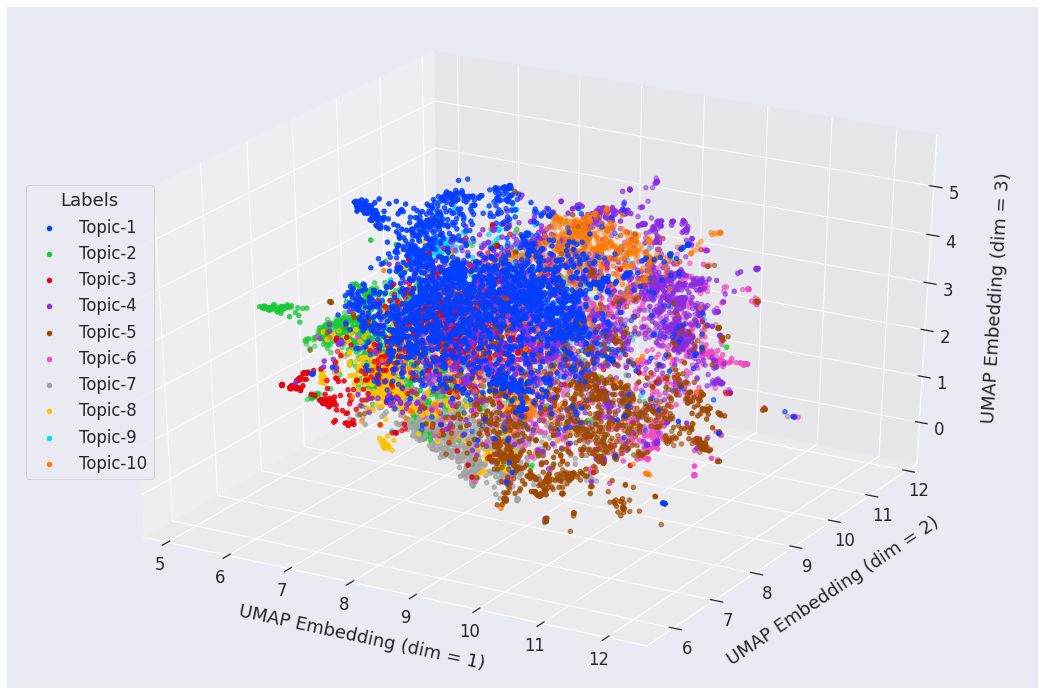

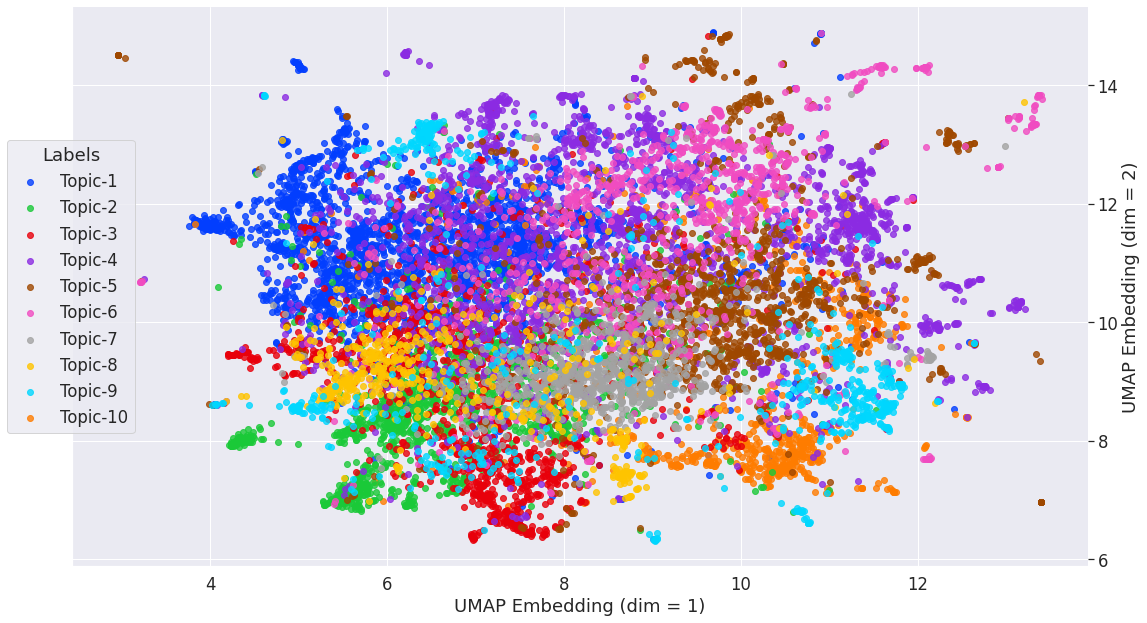

In [151]:
plot3d_df(result3d, 'bright', "12_upan_3d_no_outliers.png")
plot2d_df(result2d, 'bright', '12_upan_no_outliers.png')

In [76]:
get_words(model)

array([['brahman', 'upanishad', 'vedanta', 'brahma', 'samadhi',
        'advaita', 'bhakti', 'vedas', 'hinduism', 'upanishads', 'sutras',
        'atman', 'swami', 'acharya', 'ashram', 'vishnu', 'veda', 'yogis',
        'gita', 'prana'],
       ['consciousness', 'vedanta', 'metaphysical', 'upanishad',
        'oneness', 'dualist', 'advaita', 'duality', 'samadhi',
        'conscious', 'atman', 'brahma', 'brahman', 'self', 'egoism',
        'ramana', 'inner', 'enlightenment', 'dreamless', 'ourself'],
       ['immortality', 'immortal', 'moksha', 'samadhi', 'eternal',
        'upanishad', 'atman', 'vedanta', 'reincarnate', 'everlasting',
        'eternity', 'eternally', 'brahmacharya', 'dualist', 'samsara',
        'advaita', 'bhakti', 'oneness', 'egoism', 'brahma'],
       ['brahman', 'brahma', 'vedanta', 'upanishad', 'advaita', 'atman',
        'bhakti', 'acharya', 'devotee', 'sutras', 'ananda', 'samadhi',
        'upanishads', 'deity', 'gayatri', 'omnipresence', 'hinduism',
        'vis

## Analyse Upanishads According to Vedas

In [82]:
correction = {'Atharva-Veda':{'Mundaka':'Munda', 'Atahrvasiras':'Atahrvasirah',
                      'Ramatapini': 'Ramatapani', 'Pasupatabrahmana':'Pasupata',
                      'Bhasmajabala':'Bhasma'},
              'Krishna-Yajur-Veda':{'Kathavalli':'Katha', 'Taittiriyaka':'Taittiri',
                       'Svetasvatara': 'Svetasva', 'Avadhuta':'Avadhutaka',
                       'Yoga-kundalini': 'Yoga-kundali'},
              'Sama-Veda': {'Maitrayani':'Maitrayini','Rudrakshajabala':'Rudraksha'},
              'Sukla-Yajur-Veda': {'Isavasya':'Isa', 'Trisikhibrahmana':'Trisikhi'}
              }
def get_upan_for_vedas(data, vedas_name = 'Atharva-Veda'):
  map_veda_to_upanishads = veda_to_upanishads(data)
  upan_list = map_veda_to_upanishads[vedas_name]
  cleaned_upanishads = get_cleaned_data_dict(data)
  veda_upanishads = []
  for idx, name in enumerate(upan_list):
    if vedas_name in correction.keys():
      if name in correction[vedas_name].keys():
        name = correction[vedas_name][name]
    veda_upanishads.append(cleaned_upanishads[name])
  veda_upanishads_ = "\n".join(veda_upanishads)
  return veda_upanishads_

In [83]:
atharva_upanishads = get_upan_for_vedas(data, vedas_name = 'Atharva-Veda')
rig_upanishads = get_upan_for_vedas(data, vedas_name = 'Rig-Veda')
sama_upanishads = get_upan_for_vedas(data, vedas_name = 'Sama-Veda')
krishana_upanishads = get_upan_for_vedas(data, vedas_name = 'Krishna-Yajur-Veda')
sukla_upanishads = get_upan_for_vedas(data, vedas_name = 'Sukla-Yajur-Veda')

print(len(rig_upanishads.split('\n')),len(sama_upanishads.split('\n') ),len(atharva_upanishads.split('\n')) )
print(len(krishana_upanishads.split('\n')),len(sukla_upanishads.split('\n') ) )

1355 4798 6196
7011 5151


## Atharva Veda

In [84]:
model_atharva, _,_ = get_topics_model(atharva_upanishads.split('\n'), embedding_model='universal-sentence-encoder', num_topics = 10)
result2d_atharva = get_embeddings_df_2d(model_atharva, num_reduced_topics = 10, sigma = [2.5,2.5])
result3d_atharva = get_embeddings_df_3d(model_atharva, num_reduced_topics = 10, sigma = [2,2.5,2.5])

2021-08-28 14:57:18,664 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-08-28 14:57:19,154 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2021-08-28 14:57:26,652 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-08-28 14:57:28,794 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-08-28 14:57:47,427 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-08-28 14:57:47,737 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [156]:
result3d_atharva = get_embeddings_df_3d(model_atharva, num_reduced_topics = 10, sigma = [2,2.5,2.5])

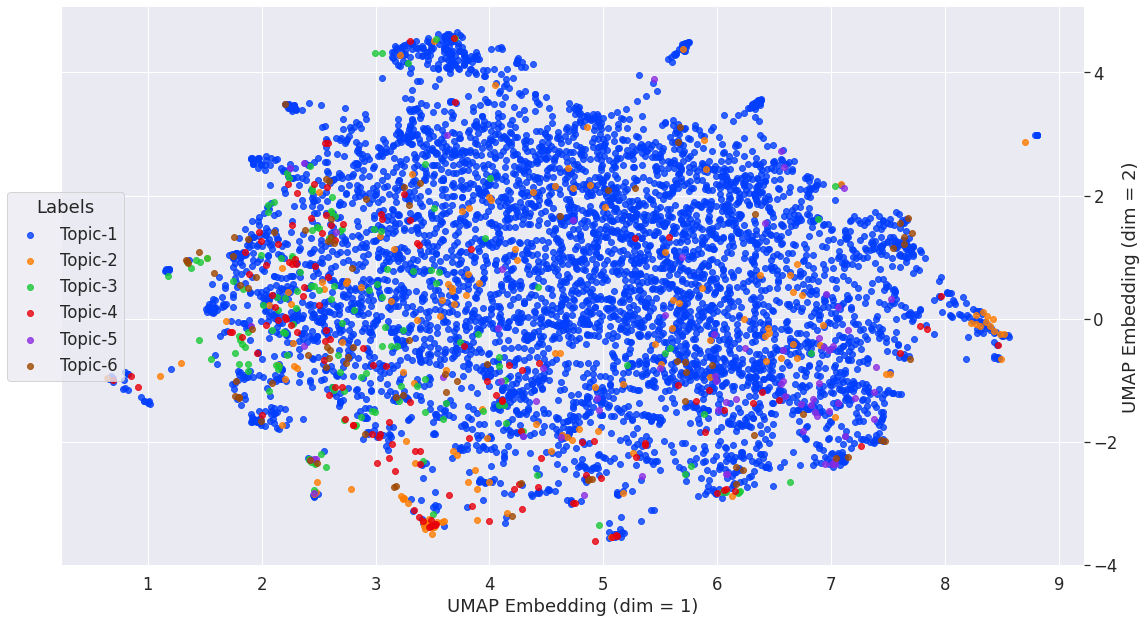

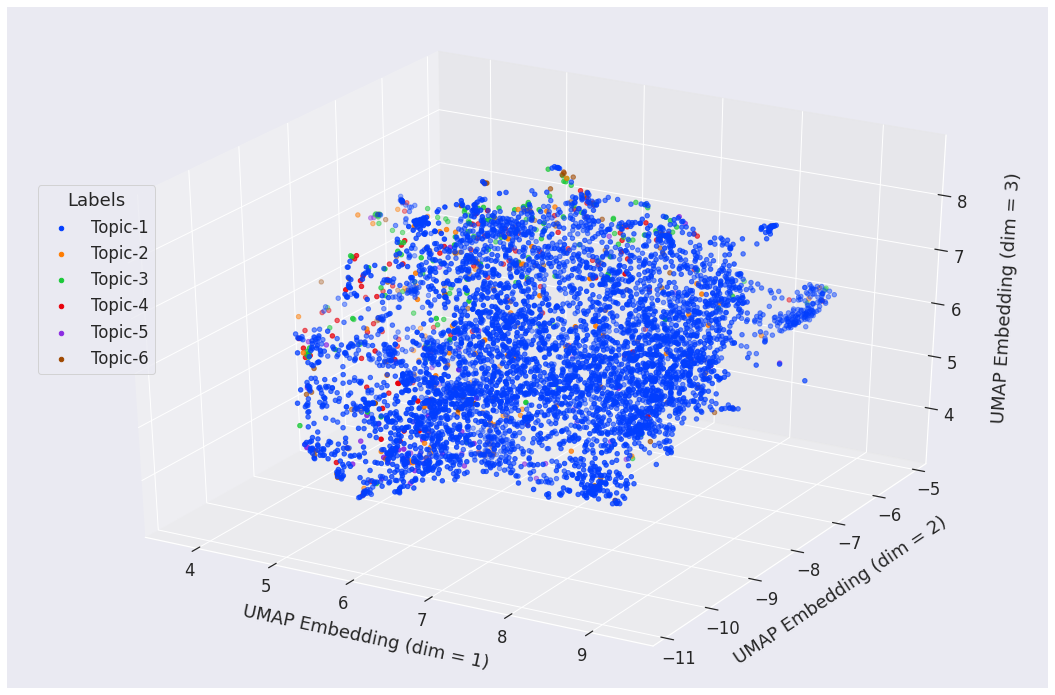

In [157]:
plot2d_df(result2d_atharva, 'bright', img_name = 'upanishads_atharva_veda_2d.png')
plot3d_df(result3d_atharva, 'bright', img_name = 'upanishads_atharva_veda_3d.png')

In [111]:
get_words(model_atharva)

array([['vedanta', 'upanishad', 'brahman', 'sloka', 'advaita', 'brahma',
        'samadhi', 'atman', 'mantras', 'kundalini', 'narayana',
        'upanishads', 'gayatri', 'narasimha', 'shakti', 'dharma',
        'moksha', 'dualist', 'vedas', 'prana'],
       ['praise', 'worship', 'sloka', 'gayatri', 'shiva', 'ear',
        'ganesha', 'hamsa', 'adoration', 'hearing', 'maha', 'eye',
        'blessing', 'om', 'upanishad', 'atman', 'loka', 'beatitude',
        'vedanta', 'goddess'],
       ['grant', 'may', 'might', 'qualify', 'liberate', 'wed', 'unite',
        'granting', 'possibility', 'poorna', 'hail', 'hopefully',
        'glory', 'prosperity', 'rejoice', 'wish', 'could', 'chandra',
        'liberation', 'vedanta'],
       ['svah', 'chaturathma', 'bhasma', 'indra', 'bhur', 'nishkala',
        'superlatively', 'ashta', 'rudiment', 'illusory', 'disputant',
        'brihat', 'continence', 'celibate', 'eschew', 'penance',
        'upanishad', 'eeshana', 'sauh', 'garuda'],
       ['gayatri',

## Rig Veda

In [114]:
model_rig, _,_ = get_topics_model(rig_upanishads.split('\n'), embedding_model='universal-sentence-encoder', num_topics = 10)
result2d_rig = get_embeddings_df_2d(model_rig, num_reduced_topics = 10, sigma = [2,2])
result3d_rig = get_embeddings_df_3d(model_rig, num_reduced_topics = 10, sigma = [1.5, 2.5,2.5])

2021-08-28 15:38:02,818 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-08-28 15:38:02,918 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2021-08-28 15:38:08,872 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-08-28 15:38:09,566 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-08-28 15:38:23,153 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-08-28 15:38:23,209 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [175]:
result2d_rig = get_embeddings_df_2d(model_rig, num_reduced_topics = 10, sigma = [1.5,1.3])

[['upanishad' 'brahman' 'brahma' 'atman' 'narayana' 'gayatri' 'meditate'
  'prana' 'shiva' 'namah' 'oneness' 'awaken' 'om' 'vishnu' 'moksha'
  'ascetic' 'veda' 'swami' 'consciousness' 'deity']
 ['speech' 'mantra' 'om' 'speaks' 'speak' 'meditate' 'upanishad'
  'syllable' 'prosperity' 'tongue' 'utterance' 'verbally' 'sri' 'hearing'
  'speaker' 'gayatri' 'liberation' 'shiva' 'gargyayani' 'ear']
 ['utterance' 'absolute' 'verbally' 'knower' 'lie' 'mentally' 'firmly'
  'speak' 'utter' 'lay' 'whatever' 'yajus' 'anything' 'say' 'mantra'
  'upanishad' 'meditate' 'gargyayani' 'delusion' 'speaks']
 ['protect' 'protector' 'speaker' 'may' 'rudra' 'narayana' 'atman' 'can'
  'teacher' 'purify' 'prana' 'capable' 'maha' 'prarabdha' 'guardian'
  'shiva' 'namah' 'vayu' 'able' 'vanquisher']
 ['mouth' 'tongue' 'eat' 'eater' 'breath' 'hunger' 'kiss' 'food' 'finger'
  'breathe' 'face' 'nostril' 'eye' 'hail' 'snake' 'head' 'speak' 'tail'
  'drink' 'smoke']
 ['self' 'thyself' 'himself' 'guru' 'reveal' 'meditat

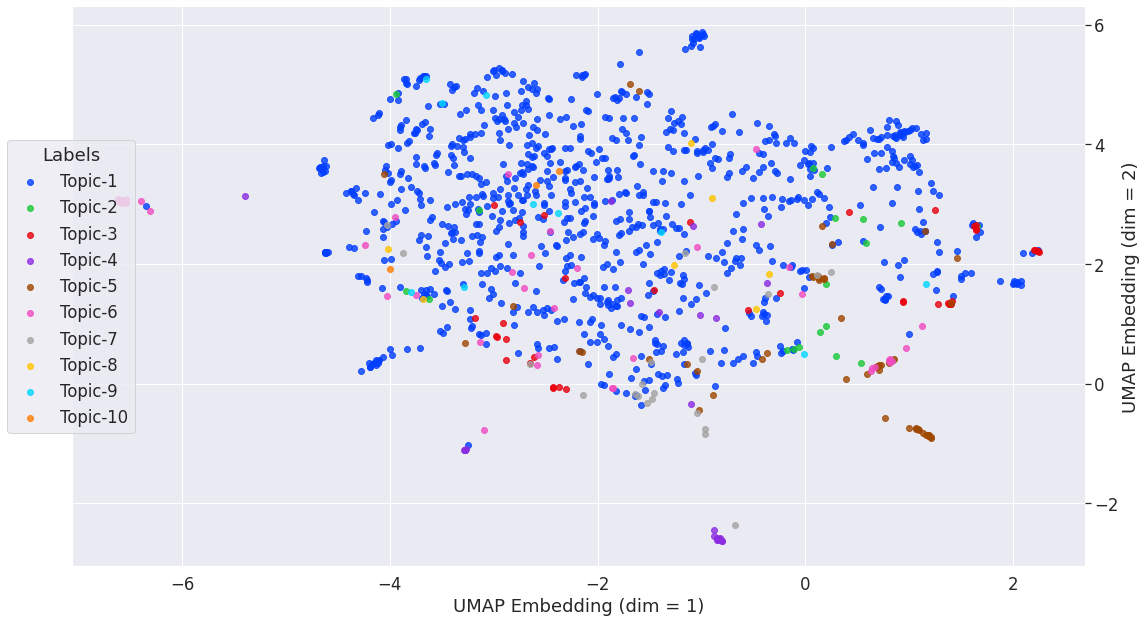

In [178]:
plot2d_df(result2d_rig, 'bright', img_name = 'upanishads_rig_veda_2d.png')
print(get_words(model_rig))

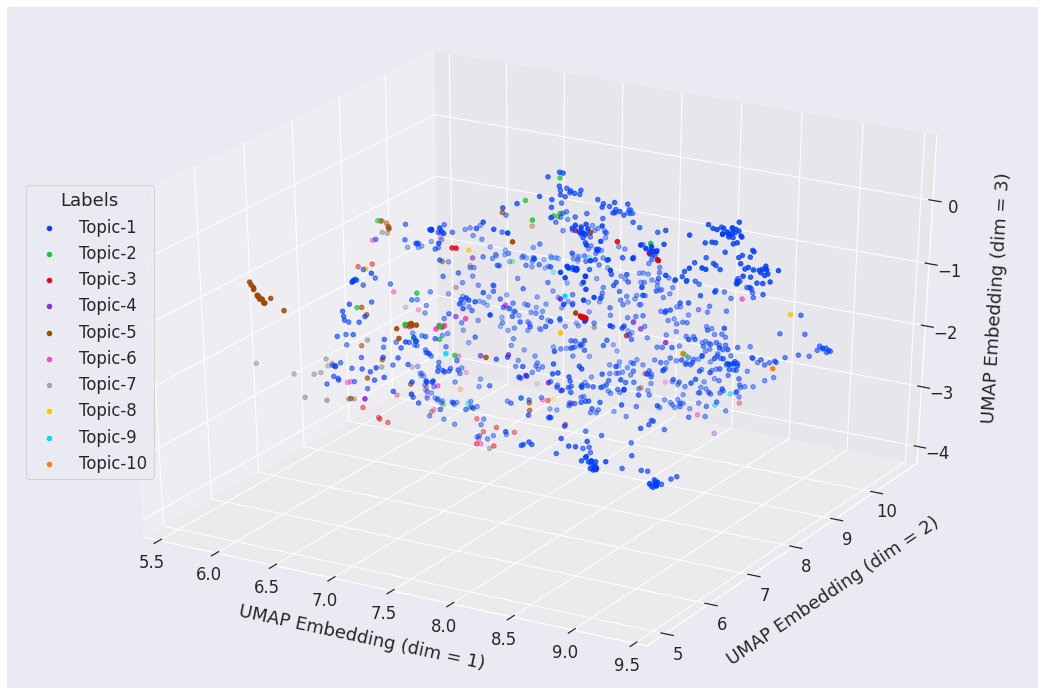

In [177]:
result3d_rig = get_embeddings_df_3d(model_rig, num_reduced_topics = 10, sigma = [1.8, 1.8,2])
plot3d_df(result3d_rig, 'bright', img_name = 'upanishads_rig_veda_3d.png')

## Sama Veda

In [179]:
model_sama, _,_ = get_topics_model(sama_upanishads.split('\n'), embedding_model='universal-sentence-encoder', num_topics = 10)
result2d_sama = get_embeddings_df_2d(model_sama, num_reduced_topics = 10, sigma = [2.5,2.5])
result3d_sama = get_embeddings_df_3d(model_sama, num_reduced_topics = 10, sigma = [2.5, 2.5,2.5])

2021-08-28 16:51:42,200 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-08-28 16:51:42,553 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2021-08-28 16:52:15,106 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-08-28 16:52:16,557 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-08-28 16:52:36,923 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-08-28 16:52:37,162 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


[['vedanta' 'upanishad' 'brahman' 'brahma' 'atman' 'samadhi' 'narayana'
  'upanishads' 'dharma' 'oneness' 'gayatri' 'prana' 'meditate' 'maitreya'
  'dhyana' 'samsara' 'duality' 'brahmacharya' 'swami' 'devotee']
 ['revere' 'sir' 'praise' 'worship' 'respect' 'reverence' 'yonder' 'hint'
  'seer' 'humility' 'enlighten' 'fool' 'dear' 'siva' 'witness' 'revered'
  'devotion' 'enlightened' 'conceited' 'subtle']
 ['happiness' 'pleased' 'happy' 'contentment' 'society' 'themselves'
  'company' 'him' 'his' 'possession' 'himself' 'firm' 'constant'
  'rejoice' 'unto' 'inwardly' 'inside' 'itself' 'wherever' 'everywhere']
 ['brahman' 'brahma' 'upanishad' 'vedanta' 'samadhi' 'purana'
  'upanishads' 'brahmin' 'vishnu' 'atman' 'devas' 'veda' 'deny' 'swami'
  'narayana' 'shiva' 'indra' 'rishis' 'siva' 'gita']
 ['denial' 'deny' 'reject' 'accept' 'prove' 'lie' 'conviction' 'delusion'
  'praise' 'upanishad' 'affirmation' 'untruth' 'ignorance' 'negation'
  'trust' 'infinite' 'moon' 'arrogant' 'falsehood' 'ign

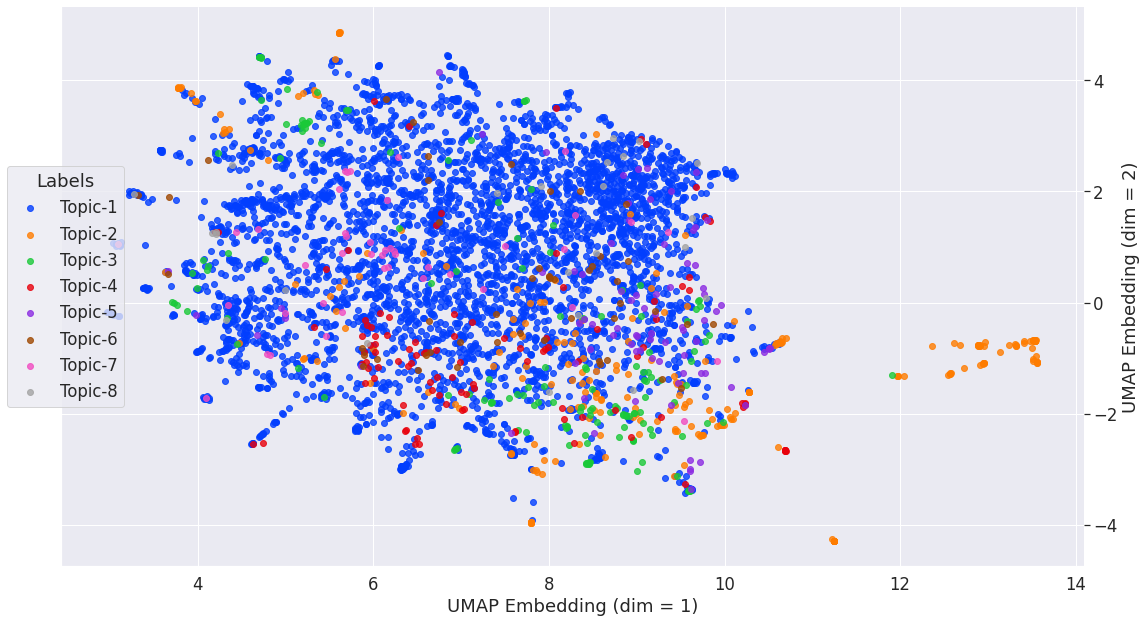

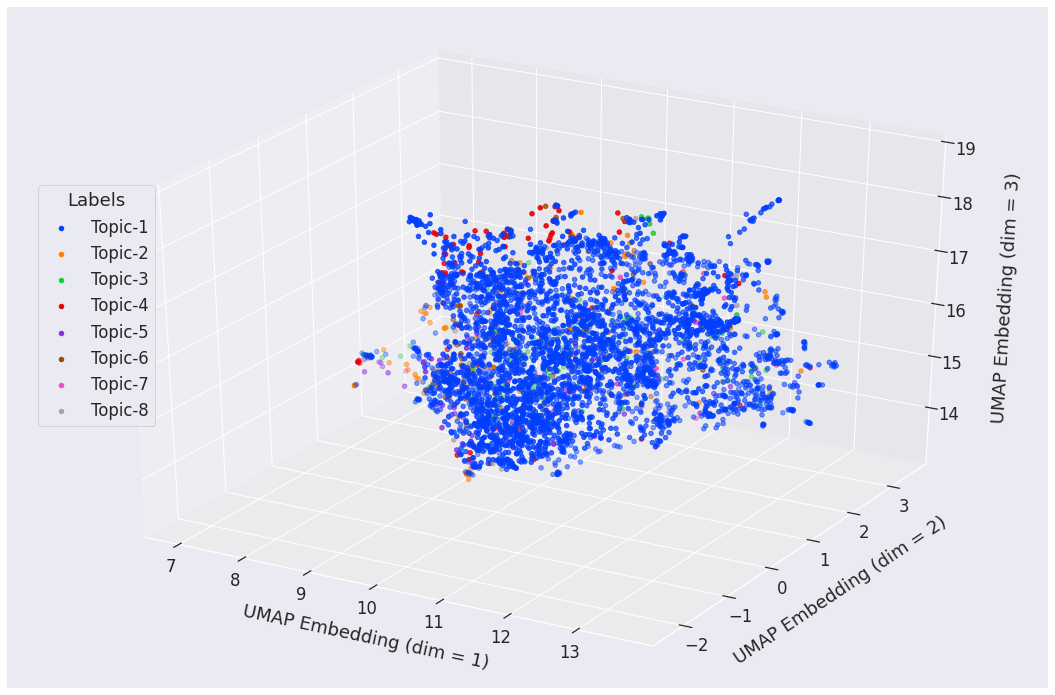

In [180]:
plot2d_df(result2d_sama, 'bright', img_name = 'upanishads_sama_veda_2d.png')
plot3d_df(result3d_sama, 'bright', img_name = 'upanishads_sama_veda_3d.png')
print(get_words(model_sama))

## Krishana Veda

2021-08-28 17:20:28,921 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-08-28 17:20:29,443 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2021-08-28 17:20:35,332 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-08-28 17:20:37,334 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-08-28 17:20:58,225 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-08-28 17:20:58,612 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


[['vedanta' 'upanishad' 'brahman' 'advaita' 'samadhi' 'brahma' 'atman'
  'bhakti' 'kundalini' 'upanishads' 'sutras' 'narayana' 'mantras'
  'hinduism' 'moksha' 'vedas' 'sadhana' 'oneness' 'gayatri' 'gita']
 ['himself' 'herself' 'prostration' 'transcends' 'him' 'her' 'itself'
  'carefully' 'worship' 'themselves' 'speaks' 'unto' 'attend' 'devas'
  'upanishad' 'impure' 'hamsa' 'toss' 'indra' 'pray']
 ['oppose' 'together' 'dispute' 'pranayama' 'unite' 'work' 'mutually'
  'pranic' 'vedic' 'adjunct' 'vayu' 'ii' 'energy' 'capable' 'detrimental'
  'ahimsa' 'mantra' 'oneness' 'simultaneously' 'gayatri']
 ['peace' 'ahimsa' 'tranquility' 'peaceful' 'shanti' 'oneness' 'om'
  'tranquil' 'vedanta' 'moksha' 'gita' 'ananda' 'brahma' 'meditation'
  'honour' 'dharma' 'meditate' 'samadhi' 'krishna' 'upanishads']]


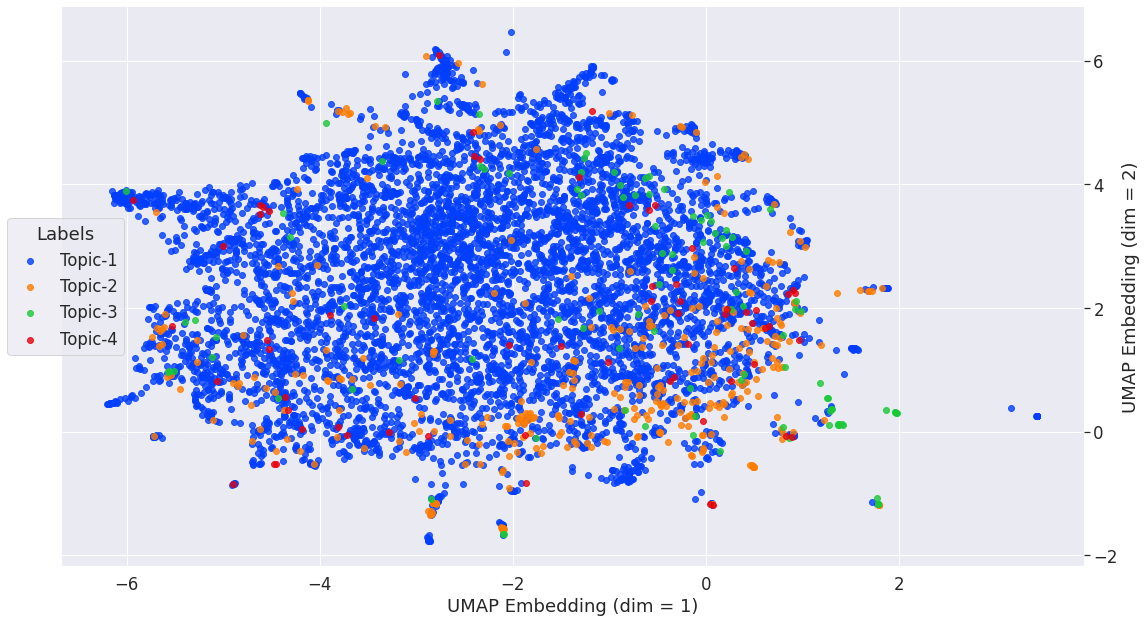

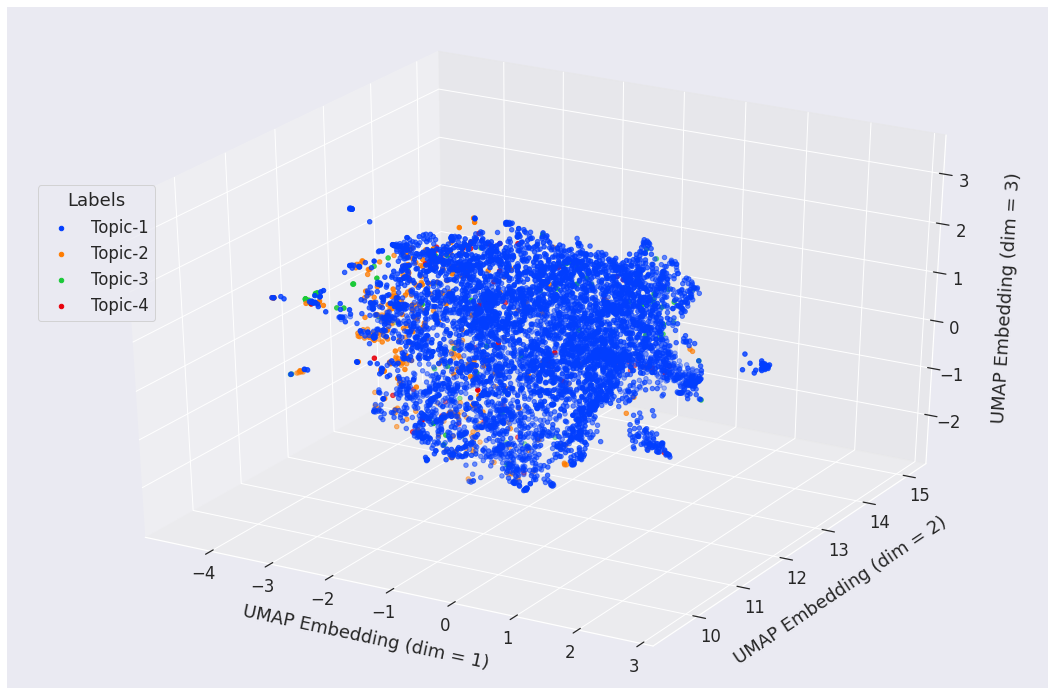

In [181]:
model_krishana, _,_ = get_topics_model(krishana_upanishads.split('\n'), embedding_model='universal-sentence-encoder', num_topics = 10)
result2d_krishana = get_embeddings_df_2d(model_krishana, num_reduced_topics = 10, sigma = [2.5,2.5])
result3d_krishana = get_embeddings_df_3d(model_krishana, num_reduced_topics = 10, sigma = [2.5, 2.5,2.5])
plot2d_df(result2d_krishana, 'bright', img_name = 'upanishads_krishana_veda_2d.png')
plot3d_df(result3d_krishana, 'bright', img_name = 'upanishads_krishana_veda_3d.png')
print(get_words(model_krishana))

## Sukla Veda

2021-08-28 17:22:55,340 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-08-28 17:22:55,743 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2021-08-28 17:23:01,422 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-08-28 17:23:03,036 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-08-28 17:23:23,194 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-08-28 17:23:23,474 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


[['vedanta' 'upanishad' 'brahman' 'advaita' 'atman' 'brahma' 'samadhi'
  'narayana' 'upanishads' 'oneness' 'formless' 'moksha' 'duality' 'prana'
  'gayatri' 'ananda' 'vedas' 'devotee' 'meditate' 'swami']
 ['these' 'four' 'whoever' 'those' 'self' 'whosoever' 'oneness' 'this'
  'fourth' 'whose' 'brahma' 'three' 'whom' 'flesh' 'such' 'vedanta' 'who'
  'they' 'threefold' 'therein']
 ['son' 'grandson' 'his' 'he' 'grandfather' 'father' 'offspring' 'its'
  'rishi' 'progeny' 'kinsman' 'jesus' 'him' 'sound' 'godhead' 'sa'
  'among' 'descendant' 'akasha' 'disciple']
 ['infinite' 'brahman' 'universe' 'brahma' 'vedanta' 'advaita'
  'upanishad' 'atman' 'cosmic' 'om' 'samadhi' 'unlimited' 'endless'
  'moksha' 'samsara' 'transcendent' 'formless' 'oneness' 'eternal'
  'shiva']
 ['infinite' 'universe' 'brahma' 'brahman' 'vedanta' 'advaita' 'atman'
  'cosmic' 'endless' 'finite' 'unlimited' 'eternally' 'eternal' 'oneness'
  'limitless' 'samsara' 'upanishad' 'moksha' 'samadhi' 'formless']
 ['indra' 'amana

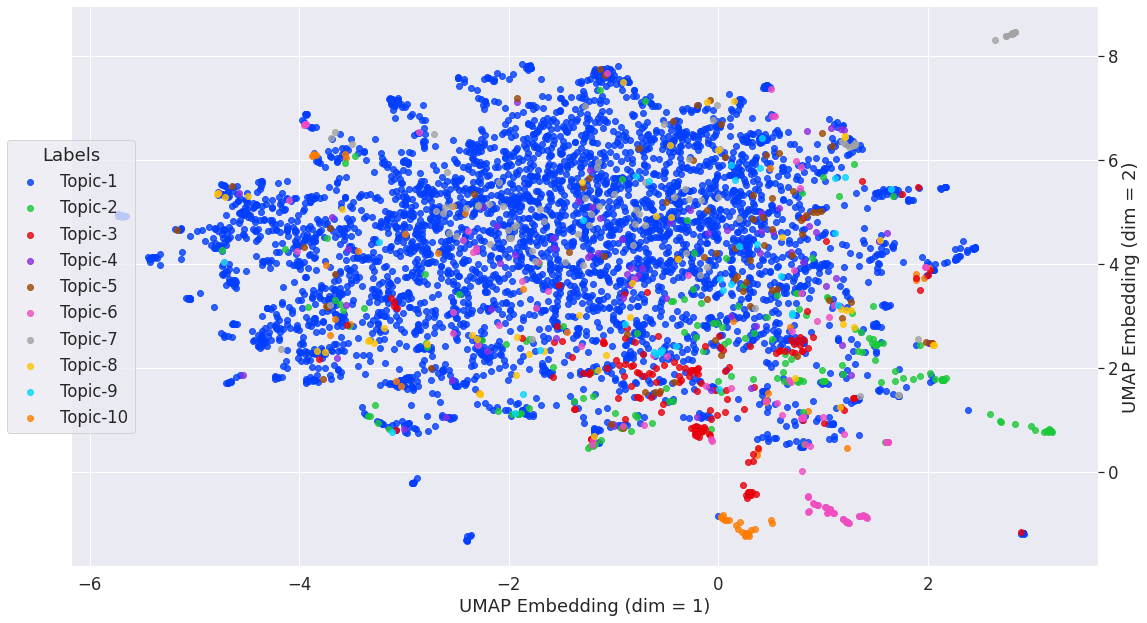

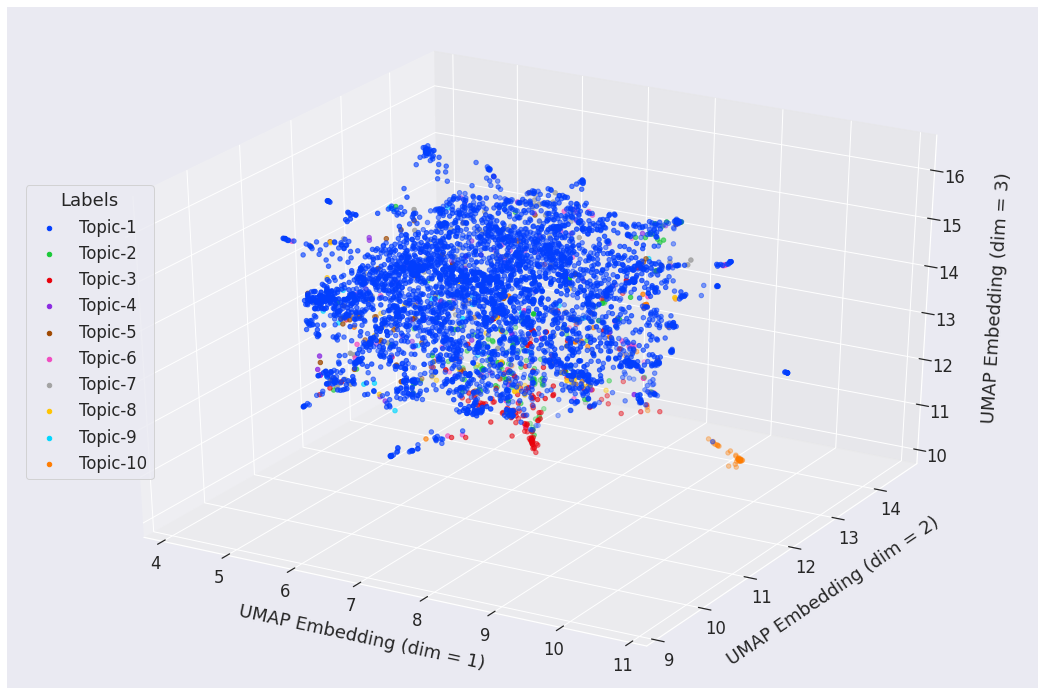

In [182]:
model_sukla, _,_ = get_topics_model(sukla_upanishads.split('\n'), embedding_model='universal-sentence-encoder', num_topics = 10)
result2d_sukla = get_embeddings_df_2d(model_sukla, num_reduced_topics = 10, sigma = [2.5,2.5])
result3d_sukla = get_embeddings_df_3d(model_sukla, num_reduced_topics = 10, sigma = [2.5, 2.5,2.5])
plot2d_df(result2d_sukla, 'bright', img_name = 'upanishads_sukla_veda_2d.png')
plot3d_df(result3d_sukla, 'bright', img_name = 'upanishads_sukla_veda_3d.png')
print(get_words(model_sukla))

## Combine Sukla and Krishana Yajur Veda to form **Yajur Veda**

In [183]:
yajur_upanishads = '\n'.join([sukla_upanishads, krishana_upanishads])
len(yajur_upanishads.split('\n'))

12162

2021-08-28 17:34:09,090 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-08-28 17:34:09,970 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2021-08-28 17:34:42,522 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-08-28 17:34:45,712 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-08-28 17:35:06,498 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-08-28 17:35:07,251 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


[['vedanta' 'upanishad' 'advaita' 'atman' 'brahman' 'brahma' 'samadhi'
  'dualism' 'oneness' 'bhakti' 'upanishads' 'moksha' 'kundalini' 'gita'
  'narayana' 'hinduism' 'tantra' 'metaphysical' 'sutras' 'samsara']
 ['vedanta' 'brahman' 'upanishad' 'brahma' 'advaita' 'bhakti' 'atman'
  'samadhi' 'formless' 'dualism' 'upanishads' 'oneness' 'sutras' 'vedas'
  'omnipresent' 'sadhana' 'hinduism' 'metaphysical' 'moksha' 'tantra']
 ['vedanta' 'atman' 'dualism' 'samadhi' 'upanishad' 'organ' 'tantra'
  'corporeal' 'brahman' 'advaita' 'gayatri' 'organs' 'kundalini'
  'mantras' 'bodily' 'prana' 'duality' 'brahma' 'formless' 'body']
 ['brahman' 'upanishad' 'brahma' 'vedas' 'bhakti' 'vedanta' 'shiva'
  'vishnu' 'hinduism' 'advaita' 'narayana' 'upanishads' 'hanuman' 'atman'
  'veda' 'indra' 'devas' 'samadhi' 'mantras' 'kundalini']
 ['ourselves' 'ourself' 'self' 'vedanta' 'oneself' 'metaphysical'
  'consciousness' 'egoism' 'oneness' 'upanishad' 'inner' 'dualism'
  'unknowable' 'dreamless' 'ego' 'duality

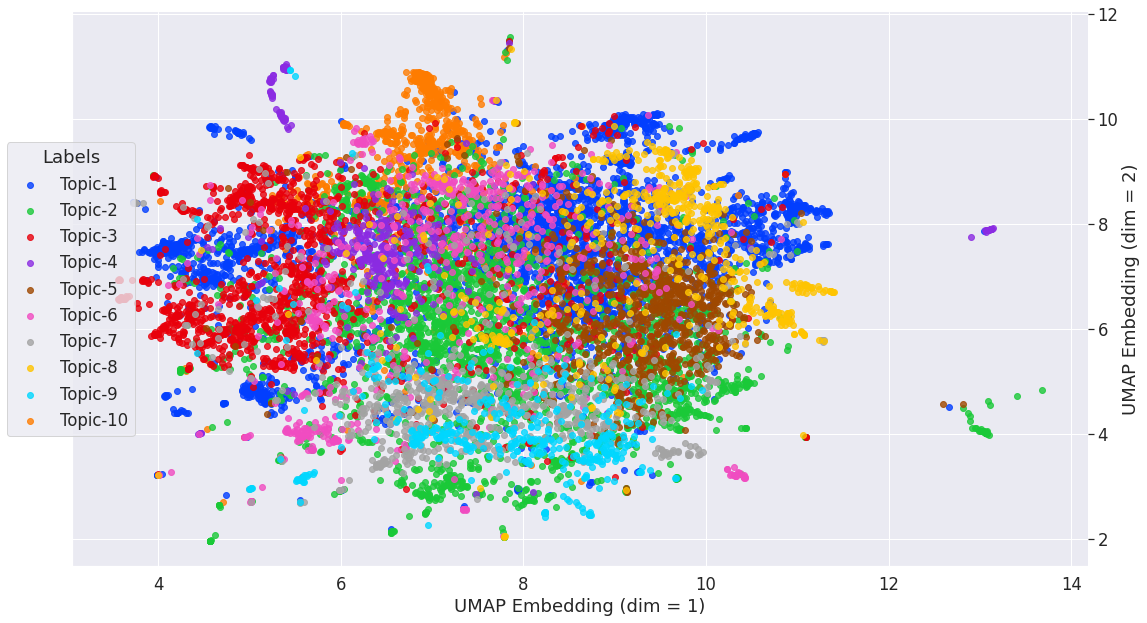

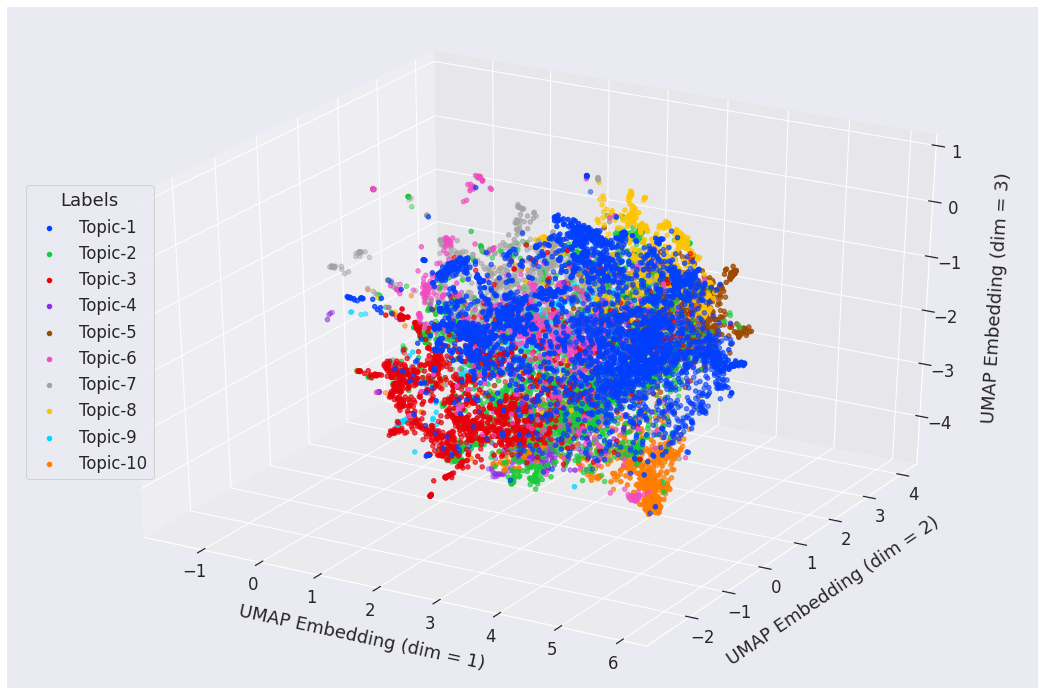

In [185]:
model_yajur, _,_ = get_topics_model(yajur_upanishads.split('\n'), embedding_model='universal-sentence-encoder', num_topics = 10)
result2d_yajur = get_embeddings_df_2d(model_yajur, num_reduced_topics = 10, sigma = [2.5,2.5])
result3d_yajur = get_embeddings_df_3d(model_yajur, num_reduced_topics = 10, sigma = [2.5, 2.5,2.5])
plot2d_df(result2d_yajur, 'bright', img_name = 'upanishads_yajur_veda_2d.png')
plot3d_df(result3d_yajur, 'bright', img_name = 'upanishads_yajur_veda_3d.png')
print(get_words(model_yajur))

## Complete 108 Upanishads

2021-08-28 18:22:54,648 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-08-28 18:22:56,276 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2021-08-28 18:23:01,419 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-08-28 18:23:08,370 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-08-28 18:23:43,998 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-08-28 18:23:50,057 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


[['upanishad' 'brahman' 'advaita' 'vedanta' 'atman' 'samadhi' 'narayana'
  'sloka' 'brahma' 'bhakti' 'hinduism' 'moksha' 'tantra' 'acharya'
  'upanishads' 'sutras' 'oneness' 'prana' 'vedas' 'narasimha']
 ['vedanta' 'upanishad' 'sloka' 'brahman' 'mantras' 'brahma' 'advaita'
  'atman' 'gayatri' 'samadhi' 'tantra' 'bhakti' 'upanishads' 'aum'
  'kundalini' 'sutras' 'vedas' 'hinduism' 'meditate' 'shakti']
 ['vedanta' 'brahma' 'upanishad' 'advaita' 'oneness' 'brahman' 'dualist'
  'dualism' 'metaphysical' 'existence' 'consciousness' 'nonexistence'
  'universe' 'formless' 'samadhi' 'duality' 'unknowable' 'emptiness'
  'atman' 'individuality']
 ['himself' 'him' 'his' 'sloka' 'devotee' 'brahma' 'he' 'narasimha'
  'brahman' 'acharya' 'lordship' 'govinda' 'advaita' 'atman' 'vedanta'
  'obeys' 'shri' 'maitreya' 'son' 'ascetic']
 ['dualism' 'dualist' 'vedanta' 'samadhi' 'consciousness' 'oneness'
  'metaphysical' 'advaita' 'meditation' 'meditative' 'upanishad'
  'unconsciousness' 'meditates' 'meditat

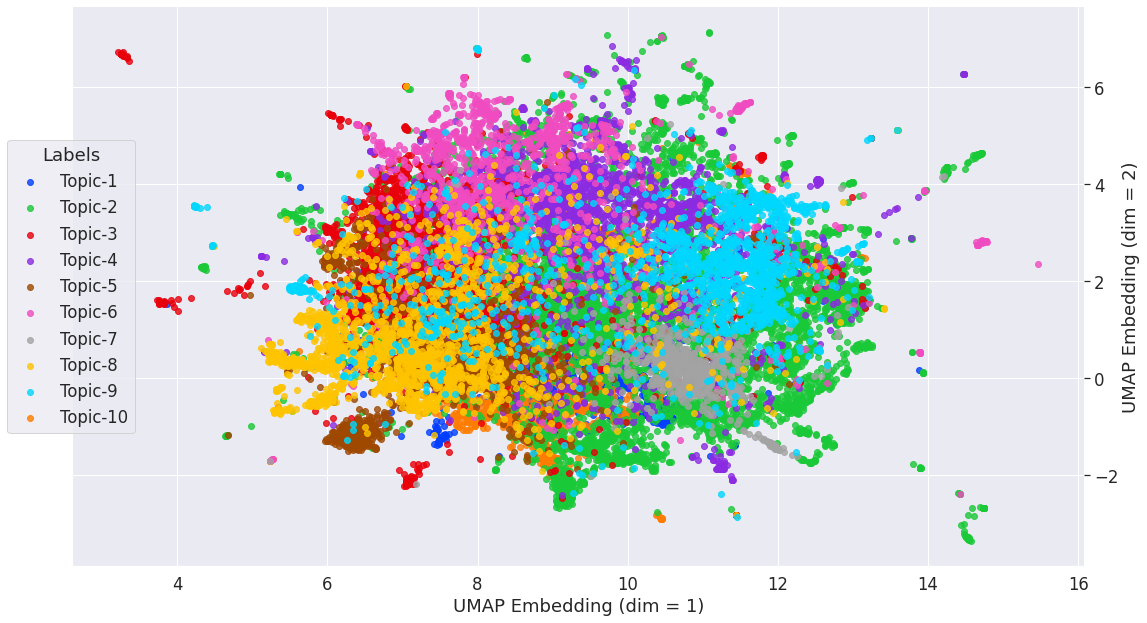

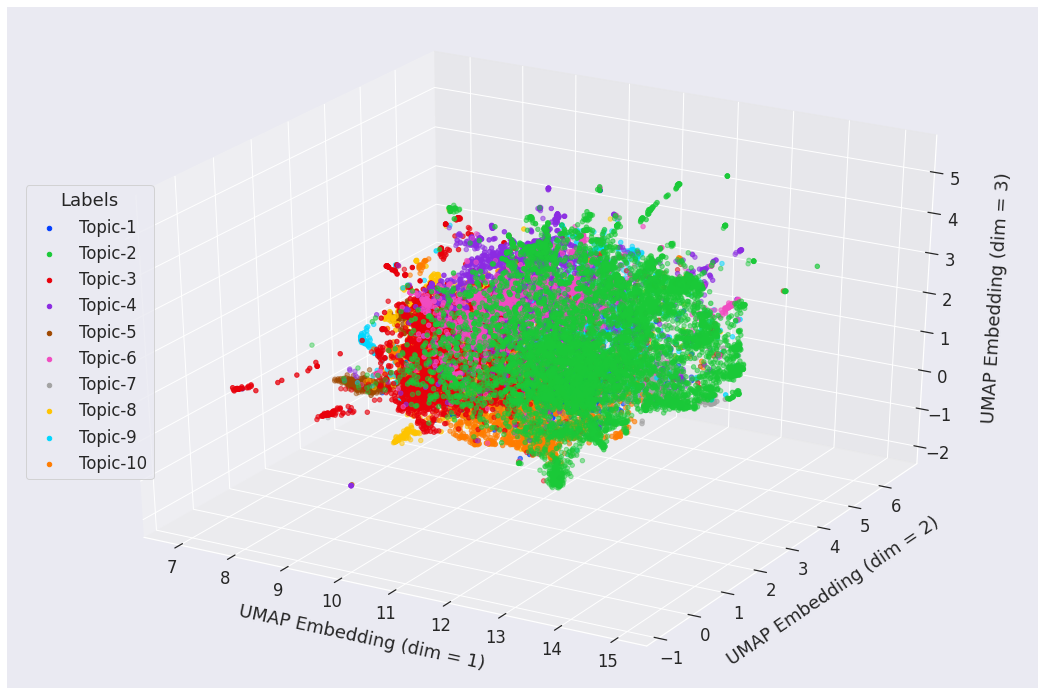

In [186]:
all_108_upanishads = join_upanishads(data, 108)
model_all, _,_ = get_topics_model(all_108_upanishads.split('\n'), embedding_model='universal-sentence-encoder', num_topics = 30)
result2d_all = get_embeddings_df_2d(model_all, num_reduced_topics = 10, sigma = [2.5,2.5])
result3d_all = get_embeddings_df_3d(model_all, num_reduced_topics = 10, sigma = [2.5, 2.5,2.5])
plot2d_df(result2d_all, 'bright', img_name = 'upanishads_108_upanishads_2d.png')
plot3d_df(result3d_all, 'bright', img_name = 'upanishads_108_upanishads_3d.png')
print(get_words(model_all))

[['upanishad' 'brahman' 'advaita' 'vedanta' 'atman' 'samadhi' 'narayana'
  'sloka' 'brahma' 'bhakti' 'hinduism' 'moksha' 'tantra' 'acharya'
  'upanishads' 'sutras' 'oneness' 'prana' 'vedas' 'narasimha']
 ['vedanta' 'upanishad' 'sloka' 'brahman' 'mantras' 'brahma' 'advaita'
  'atman' 'gayatri' 'samadhi' 'tantra' 'bhakti' 'upanishads' 'aum'
  'kundalini' 'sutras' 'vedas' 'hinduism' 'meditate' 'shakti']
 ['vedanta' 'brahma' 'upanishad' 'advaita' 'oneness' 'brahman' 'dualist'
  'dualism' 'metaphysical' 'existence' 'consciousness' 'nonexistence'
  'universe' 'formless' 'samadhi' 'duality' 'unknowable' 'emptiness'
  'atman' 'individuality']
 ['himself' 'him' 'his' 'sloka' 'devotee' 'brahma' 'he' 'narasimha'
  'brahman' 'acharya' 'lordship' 'govinda' 'advaita' 'atman' 'vedanta'
  'obeys' 'shri' 'maitreya' 'son' 'ascetic']
 ['dualism' 'dualist' 'vedanta' 'samadhi' 'consciousness' 'oneness'
  'metaphysical' 'advaita' 'meditation' 'meditative' 'upanishad'
  'unconsciousness' 'meditates' 'meditat

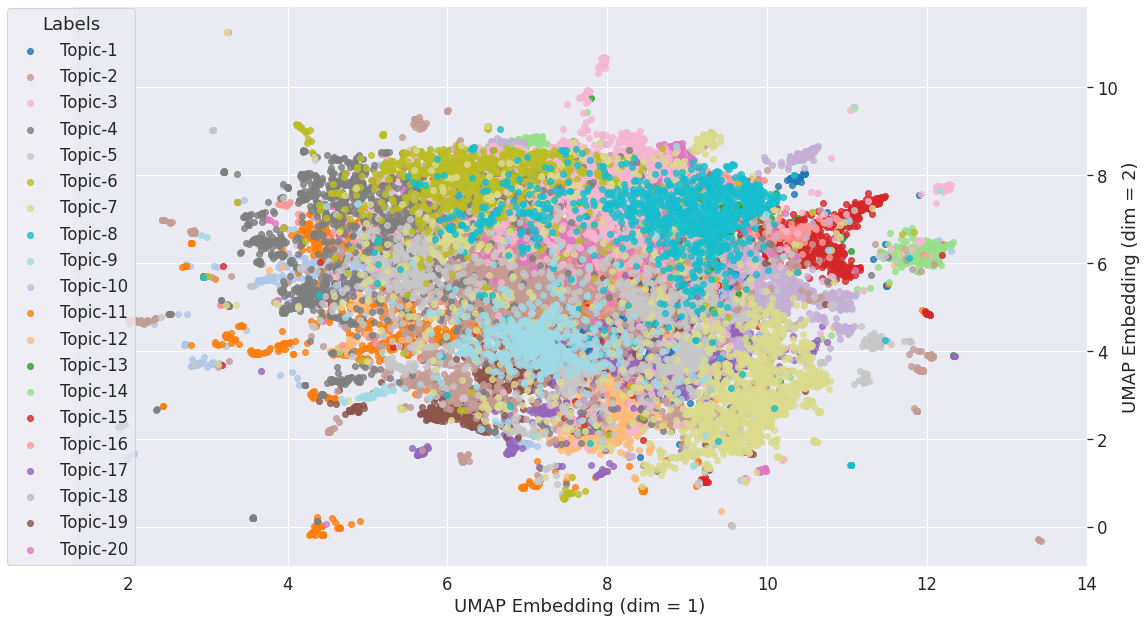

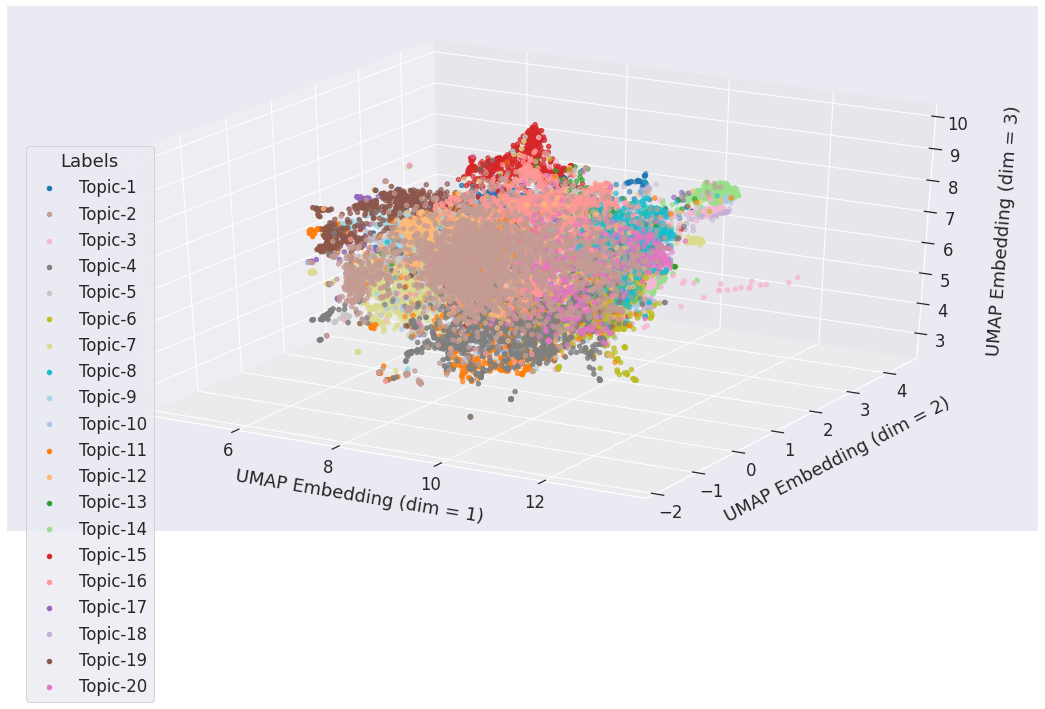

In [187]:
result2d_all = get_embeddings_df_2d(model_all, num_reduced_topics = 20, sigma = [2.5,2.5])
result3d_all = get_embeddings_df_3d(model_all, num_reduced_topics = 20, sigma = [2.5, 2.5,2.5])
plot2d_df(result2d_all, 'tab20', img_name = 'upanishads_108_upanishads_2d_20_topic.png')
plot3d_df(result3d_all, 'tab20', img_name = 'upanishads_108_upanishads_3d_20_topic.png')
print(get_words(model_all))

In [199]:
def plot3d_df(result, palet, img_name = 'no_name_image_3d.png'):
  
  result = result.sort_values(by=['Labels'])
  fig = plt.figure(figsize=(15,10))
  ax = fig.add_subplot(111, projection='3d')

  x = result['x_embeddings']
  y = result['y_embeddings']
  z = result['z_embeddings']
  
  ax.set_xlabel('UMAP Embedding (dim = 1)', labelpad = 20.0)
  ax.set_ylabel('UMAP Embedding (dim = 2)', labelpad = 20.0)
  ax.set_zlabel('UMAP Embedding (dim = 3)', labelpad = 20.0)

  clrs = sns.color_palette(palet, 20).as_hex()

  for idx, topics in enumerate(result.Labels.unique()):
      ax.scatter(x[result.Labels == topics],y[result.Labels == topics],
                 z[result.Labels == topics],label = topics, c = clrs[idx])
  
  handles, labels = ax.get_legend_handles_labels()
  # sort both labels and handles by labels
  labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
  ax.legend(handles, labels, loc='best', bbox_to_anchor=(0.15, 1.0), title="Labels")
  plt.tight_layout()
  plt.savefig(img_name, dpi =400)
plot3d_df(result3d_all, 'colorblind', img_name = 'upanishads_108_upanishads_3d_20_topic.png')

In [200]:
get_words(model_all, 20, 20)

array([['upanishad', 'advaita', 'brahman', 'atman', 'vedanta', 'samadhi',
        'sloka', 'narayana', 'brahma', 'bhakti', 'acharya', 'moksha',
        'tantra', 'hinduism', 'oneness', 'upanishads', 'sutras',
        'narasimha', 'prana', 'vedas'],
       ['brahman', 'brahma', 'upanishad', 'vedanta', 'advaita', 'bhakti',
        'sloka', 'atman', 'upanishads', 'vedas', 'puranas', 'hinduism',
        'samadhi', 'narayana', 'veda', 'acharya', 'moksha', 'devas',
        'shakti', 'saraswati'],
       ['vedanta', 'oneness', 'advaita', 'upanishad', 'consciousness',
        'brahman', 'brahma', 'dualism', 'metaphysical', 'dualist',
        'duality', 'samadhi', 'atman', 'egoism', 'formless', 'universe',
        'self', 'unknowable', 'individuality', 'existence'],
       ['vedanta', 'upanishad', 'resembles', 'duality', 'sloka',
        'perceives', 'humbly', 'awaken', 'brahman', 'hail', 'brahma',
        'prevails', 'rejoices', 'sanatana', 'foolishness', 'praise',
        'atman', 'eternally'